In [1]:
import sys
import os
import torch
import torch.nn as nn
import numpy.random as random
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import seaborn as sns

sns.set_theme()
sns.set_context("paper")

sys.path.append("./")

In [2]:
from autoencode import AEEnsemble
from models import Classifier
from datasets import SupervisedDataset, UnsupervisedDataset

In [3]:
unsup_data = UnsupervisedDataset("/export/gaon1/data/jteneggi/DL/alm", session_idx=[0])
unsup_spikes = []
for idx, (_unsup_spikes, _) in enumerate(unsup_data):
    if len(_unsup_spikes) > 0:
        # print(_unsup_spikes.shape)
        unsup_spikes.append(_unsup_spikes)
unsup_spikes = np.concatenate(unsup_spikes)
print(unsup_spikes.shape)

(423520, 39)


In [4]:
sup_spikes, sup_targets = SupervisedDataset("/export/gaon1/data/jteneggi/DL/pedreira")[0]
print(sup_spikes.shape)

(12012, 39)


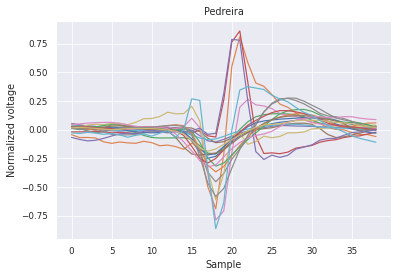

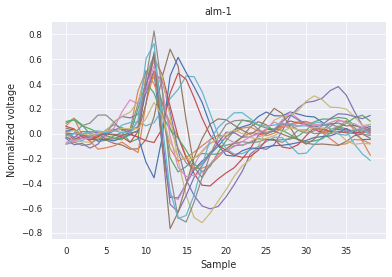

In [15]:
plt.plot(np.transpose(unsup_spikes[np.random.choice(range(len(unsup_spikes)), 20, replace=False)]))
plt.xlabel("Sample")
plt.ylabel("Normalized voltage")
plt.title("Pedreira")
plt.savefig("predreira_examples.eps")
plt.show()
plt.plot(np.transpose(sup_spikes[np.random.choice(range(len(sup_spikes)), 20, replace=False)]))
plt.xlabel("Sample")
plt.ylabel("Normalized voltage")
plt.title("alm-1")
plt.savefig("alm_examples.eps")
plt.show()

In [5]:
spike_batch_size = 128
n_ae_iter = 120
n_class_iter = 6
ratio = n_ae_iter/n_class_iter
sup_L = len(sup_spikes)
unsup_L = len(unsup_spikes)
unsup_epoch_L = int(ratio * sup_L)

print(sup_L, unsup_epoch_L)

12012 240240


In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "9"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

ae = AEEnsemble(batch_size=1, device=device)
ae.load()

fc = Classifier(num_classes=20, device=device)

Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0


Encoded session 1, 10000 spikes
Learning manifold for latent embeddings


Text(0, 0.5, 'Second dimension')

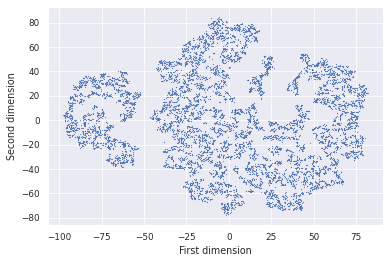

In [8]:
tsne = TSNE(n_components=2)

i = 1
spikes_idx = np.random.choice(range(unsup_L), 10000, replace=False)
spikes = unsup_spikes[spikes_idx]

spikes = torch.from_numpy(spikes).float().to(device)
latent_vecs = [e(spikes) for e in ae.encoders]
latent = torch.cat(latent_vecs, dim=1).detach().cpu()
print(f"Encoded session {i}, {spikes.size(0)} spikes")
# gt_classes = data.spike_classes[i].squeeze()
print(f"Learning manifold for latent embeddings")
latent_manifold = tsne.fit_transform(latent.cpu())

plt.scatter(latent_manifold[:, 0], latent_manifold[:, 1], marker=".", s=.5)
plt.xlabel("First dimension")
plt.ylabel("Second dimension")

Encoded session 1, 12012 spikes
Learning manifold for latent embeddings


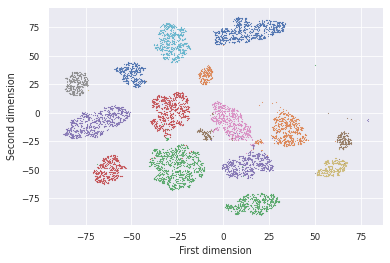

Encoded session 1, 12784 spikes
Learning manifold for latent embeddings


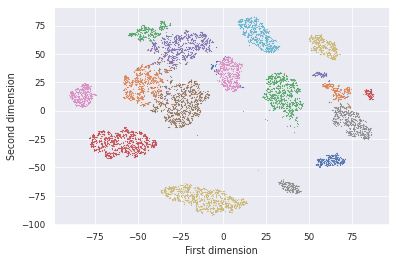

Encoded session 1, 9277 spikes
Learning manifold for latent embeddings


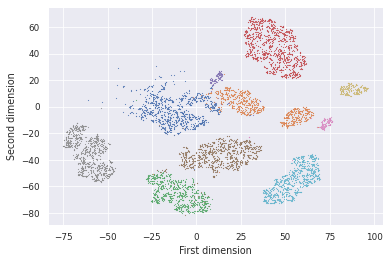

Encoded session 1, 5127 spikes
Learning manifold for latent embeddings


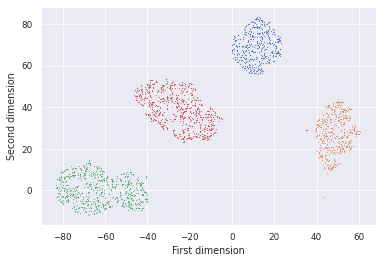

In [13]:
for sup_idx in range(4):
    sup_spikes, sup_targets = SupervisedDataset("/export/gaon1/data/jteneggi/DL/pedreira")[sup_idx]
    spikes = torch.from_numpy(sup_spikes).float().to(device)
    latent_vecs = [e(spikes) for e in ae.encoders]
    latent = torch.cat(latent_vecs, dim=1).detach().cpu()
    print(f"Encoded session {i}, {spikes.size(0)} spikes")
    # gt_classes = data.spike_classes[i].squeeze()
    print(f"Learning manifold for latent embeddings")
    latent_manifold = tsne.fit_transform(latent.cpu())

    for c in range(1, 20):
        c_manifold = latent_manifold[sup_targets == c]
        plt.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)
    plt.xlabel("First dimension")
    plt.ylabel("Second dimension")
    plt.show()